# Run if on Google Colab

In [1]:
%pip install git+https://github.com/deepmind/dm-haiku
%pip install jaxopt
%pip install optax

Note: you may need to restart the kernel to use updated packages.Collecting git+https://github.com/deepmind/dm-haiku
  Cloning https://github.com/deepmind/dm-haiku to c:\users\sadie\appdata\local\temp\pip-req-build-fu8m_n8o
  Resolved https://github.com/deepmind/dm-haiku to commit 48dcadd19c2c1b466fee1f675f8cf27303764401
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku 'C:\Users\sadie\AppData\Local\Temp\pip-req-build-fu8m_n8o'


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Set up Environment

In [2]:

#Set seed
seed = 42

# Import packages
import optax
from typing import NamedTuple
import functools
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import haiku as hk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from itertools import product
import pickle
import jaxopt
from typing import Callable
from typing import Dict
from typing import NamedTuple
from flax import struct
import stochasticfisher as sf
import myjaxutil as myjax
from mynetworks import LinearLayer
import pandas as pd
from jax import config
import os
import seaborn as sns
import imageio
import statsmodels.api as sm


# config.update("jax_debug_nans", True)
jax.numpy.set_printoptions(precision=3, threshold = 3)

# Augmented Lagrangian Method

## Helper functions

In [3]:
def get_lagrangian_function_exploit(obj, exploit):
    """
    Returns a function that computes the Lagrangian function of the given objective function and exploit function.

    Args:
    obj: A function that takes in two arguments, l_action and f_action, and returns a scalar value.
    exploit: A function that takes in two arguments, l_action and f_action, and returns a scalar value.

    Returns:
    A function that takes in three arguments, l_action, f_action, and langmult, and returns a scalar value.
    """

    @jax.jit
    def lagrangian(l_action, f_action, langmult, init_exploit_params):
        """
        Computes the Lagrangian function of the given objective function and exploit function.

        Args:
        l_action: A numpy array representing the action of the learner.
        f_action: A numpy array representing the action of the follower.
        langmult: A scalar value representing the Lagrange multiplier.

        Returns:
        A scalar value representing the Lagrangian function.
        """

        return jnp.squeeze(obj(l_action, f_action) + langmult * exploit(l_action, f_action, **init_exploit_params))

    return lagrangian


def get_penalty_function_exploit(obj, exploit):
    """
    Returns a function that computes the penalty function of the given objective function and exploit function.

    Args:
    obj: A function that takes in two arguments, l_action and f_action, and returns a scalar value.
    exploit: A function that takes in two arguments, l_action and f_action, and returns a scalar value.

    Returns:
    A function that takes in four arguments, l_action, f_action, langmult, and beta, and returns a scalar value.
    """

    @jax.jit
    def penalty_function(l_action, f_action, langmult, beta, init_exploit_params):
        """
        Computes the penalty function of the given objective function and exploit function.

        Args:
        l_action: A numpy array representing the action of the learner.
        f_action: A numpy array representing the action of the follower.
        langmult: A scalar value representing the Lagrange multiplier.
        beta: A scalar value representing the penalty parameter.

        Returns:
        A scalar value representing the penalty function.
        """
        f_exploit, exploit_params = exploit(l_action, f_action, **init_exploit_params)
        return jnp.squeeze(obj(l_action, f_action) + langmult * f_exploit + (beta/2)*jnp.power(f_exploit, 2)), exploit_params

    return penalty_function

## Main Routine

In [4]:
def run_augmented_lagranian_exploit(problem, init_params, learn_rates, num_iters, beta_mult, beta, opt_name, init_exploit_params = {}, evaluate = lambda x,y: {"Penalty Function Value":[None], "Exploitability": [None]}, plot_price_prediction = lambda x,y: None):

    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    obj, exploit, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))
    penalty_func = get_penalty_function_exploit(obj, exploit)

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower), learn_rate_langmult = learn_rates
    num_iters_players, num_iters_langmult = num_iters

    # Unpack initial parameters
    l_action, f_action, langmult = init_params

    @jax.jit
    def player_step(l_action, f_action, langmult, beta, leader_opt_state, follower_opt_state, init_exploit_params):
        grads_leader, exploit_params = jax.grad(penalty_func, argnums = 0, has_aux = True)(l_action, f_action, langmult, beta, init_exploit_params)
        grads_follower, exploit_params = jax.grad(penalty_func, argnums = 1, has_aux = True)(l_action, f_action, langmult, beta, init_exploit_params)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        new_f_action = optax.apply_updates(f_action, f_updates)
        new_f_action = f_project(new_f_action)

        return (new_l_action, new_f_action), (new_leader_opt_state, new_follower_opt_state), exploit_params

    @jax.jit
    def langmult_step(l_action, f_action, langmult, beta, init_exploit_params):
        grads, exploit_params = jax.grad(penalty_func, argnums = 2, has_aux = True)(l_action, f_action, langmult, beta, init_exploit_params)
        negated_grads = jax.tree_util.tree_map(lambda x: -x, grads)
        updates, new_state = langmult_update(negated_grads, langmult_opt_state, langmult)
        new_langmult = optax.apply_updates(langmult, updates)
        return (new_langmult, new_state), exploit_params

    # Initialize Lagrangian Optimizer
    langmult_update, langmult_opt_state = myjax.init_optimiser(learn_rate_langmult, langmult, opt_name)

    # Initialize iteration counters
    iter_langmult = 0
    iter_player = 0

    # Initialize data dictionary to store the history of training
    data_hist = evaluate(l_action, f_action)

    figure_hist = []

    # Print initial values
    print("Lagrange multiplier: ", langmult)

    while iter_langmult <= num_iters_langmult:
        l_payoff = obj(l_action, f_action)
        exploit_val, init_exploit_params = exploit(l_action, f_action, **init_exploit_params)
        penalty_func_val, init_exploit_params = penalty_func(l_action, f_action, langmult, beta, init_exploit_params)

        print(f"\033[1m============================================================ Lagrangian Iteration -- {iter_langmult} ============================================================\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mLeader Payoff: {l_payoff:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mExploit: {exploit_val:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value: {penalty_func_val:.4f}\033[0m")


        # Reinitialize player optimizers
        leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
        follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)

        iter_player = 0
        action_norm_change = float("inf")
        while iter_player <= num_iters_players:

            print(f"\t\t**************************** Lagrangian Iteration: {iter_langmult} // Player Iteration: {iter_player}  ****************************")
            if iter_player % 1 == 0:
                fig = plot_price_prediction(l_action, f_action)
                figure_hist.append(fig)
            iter_regret = 0
            br_norm_change = float("inf")

            # Player actions update step
            (l_action, f_action), (leader_opt_state, follower_opt_state), init_exploit_params = player_step(l_action, f_action, langmult, beta, leader_opt_state, follower_opt_state, init_exploit_params)

            if iter_player % 10 == 0:
                print(f"Market Predicted: {l_action}")

            iter_player += 1

            if iter_player % 1 == 0:
                # print("Leader action:", l_action, "\nFollower action", f_action)
                # l_payoff = obj(l_action, f_action)
                exploit_val, init_exploit_params = exploit(l_action, f_action, **init_exploit_params)
                penalty_func_val, init_exploit_params = penalty_func(l_action, f_action, langmult, beta, init_exploit_params)


                # print(f"\t\t\t\t\t\t\t\033[1mLeader Payoff: {l_payoff:.4f}\033[0m")
                print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")
                print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value: {penalty_func_val:.4f}\033[0m")

                print("\t\t\t\t\t\t\t----------------------------------")
                results = evaluate(l_action, f_action)
                results["Penalty Function Value"][-1] = penalty_func_val
                results["Exploitability"][-1] = exploit_val

                data_hist = jax.tree_util.tree_map(lambda x, y: x + y, data_hist, results)


                for key, value in results.items():
                    print(f"\t\t\t\t\t\t\t\033[1m{key}\033[0m: {value[-1]:.4f}")

        (langmult, langmult_opt_state), init_exploit_params = langmult_step(l_action, f_action, langmult, beta, init_exploit_params)




        print(f"Lagrange: Multipliers {langmult}")
        print(f"Beta: {beta}")
        beta *= beta_mult
        iter_langmult += 1

    return (l_action, f_action, langmult), (data_hist, figure_hist)

# Algorithms

## Gradient Descent Ascent

In [5]:
def run_GDA(problem, init_params, goal_params, learn_rates, num_iters, opt_name="adam", epsilon=1e-2):


    exploit_hist = []
    dist_hist = []
    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    exploit, cumul_regret, neg_cumul_regret, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower) = learn_rates
    num_iters_players = num_iters

    # Unpack initial parameters
    l_action, f_action = init_params
    l_goal, f_goal = goal_params

    # @jax.jit
    def player_step(l_action, f_action, leader_opt_state, follower_opt_state):
        value_leader, grads_leader = jax.value_and_grad(cumul_regret, argnums = 0)(l_action, f_action)
        value_follower, grads_follower = jax.value_and_grad(neg_cumul_regret, argnums = 1)(l_action, f_action)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        new_f_action = optax.apply_updates(f_action, f_updates)
        new_f_action = f_project(new_f_action)

        return (new_l_action, new_f_action), (new_leader_opt_state, new_follower_opt_state)


    # Initialize iteration counters
    iter_player = 0


    # Reinitialize player optimizers
    leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
    follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)
    while iter_player <= num_iters_players:
        # Player actions update step
        (l_action, f_action), (leader_opt_state, follower_opt_state) = player_step(l_action, f_action, leader_opt_state, follower_opt_state)
        if iter_player % 10 == 0:
            exploit_val = exploit(l_action, f_action)
            exploit_hist.append(exploit_val)
            if iter_player % 1000 == 0:
                print(f"\t\t**************************** Player Iteration: {iter_player}  ****************************")
                print(f"Leader Predicted: {l_action}")
                print(f"Follower Predicted: {f_action}")
                print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")
            flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
            dist_dict = {}
            error = 0
            for key_path, value in flattened:
                # print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')
                key = jax.tree_util.keystr(key_path)[2:-2]
                dist = np.linalg.norm((value-l_goal[key])/l_goal[key])
                dist_dict[key] = dist
                error += dist
                if iter_player % 1000 == 0:
                  print(f"\t\t\t\t\t\t\t\033[1mDistance to true {key}: {dist}\033[0m")
            dist_hist.append(dist_dict)
            if error <= epsilon:
                print(f"Leader Predicted: {l_action}")
                print(f"Follower Predicted: {f_action}")
                print(f"Exploitability: {exploit_val}")
                print(f"Error: {error}")
                break
        iter_player += 1

    return (l_action, f_action), exploit_hist, dist_hist

## Max-Oracle GD

In [6]:
def run_max_oracle_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name="adam", epsilon=1e-1):


    exploit_hist = []
    dist_hist = []
    # Unpack problem which is a tuple of objective, cumulative regret, and projection functions for the leader and follower
    exploit, cumul_regret, best_response, l_project, f_project  = problem
    # project_all = lambda x: (l_project(x[0]), f_project(x[1]))

    # Unpack learning rates and number of iterations
    (learn_rate_leader, learn_rate_follower) = learn_rates
    num_iters_players = num_iters

    # Unpack initial parameters
    l_action, f_action = init_params
    l_goal, f_goal = goal_params

    # @jax.jit
    def player_step(l_action, f_action, leader_opt_state, follower_opt_state):
        value_leader, grads_leader = jax.value_and_grad(cumul_regret, argnums = 0)(l_action, f_action)
        # value_follower, grads_follower = jax.value_and_grad(neg_cumul_regret, argnums = 1)(l_action, f_action)

        l_updates, new_leader_opt_state = leader_update(grads_leader, leader_opt_state, l_action)
        new_l_action = optax.apply_updates(l_action, l_updates)
        new_l_action = l_project(new_l_action)

        # f_updates, new_follower_opt_state = follower_update(grads_follower, follower_opt_state, f_action)
        # new_f_action = optax.apply_updates(f_action, f_updates)
        new_f_action = best_response(new_l_action)
        new_f_action = f_project(new_f_action)

        return (new_l_action, new_f_action), (new_leader_opt_state)


    # Initialize iteration counters
    iter_player = 0


    # Reinitialize player optimizers
    leader_update, leader_opt_state = myjax.init_optimiser(learn_rate_leader, l_action, opt_name)
    follower_update, follower_opt_state = myjax.init_optimiser(learn_rate_follower, f_action, opt_name)
    while iter_player <= num_iters_players:
        # Player actions update step
        (l_action, f_action), (leader_opt_state) = player_step(l_action, f_action, leader_opt_state, follower_opt_state)
        if iter_player % 10 == 0:
            exploit_val = exploit(l_action, f_action)
            exploit_hist.append(exploit_val)
            if iter_player % 100 == 0:
                print(f"\t\t**************************** Player Iteration: {iter_player}  ****************************")
                print(f"Leader Predicted: {l_action}")
                print(f"Follower Predicted: {f_action}")
                print(f"\t\t\t\t\t\t\t\033[1mExploitability: {exploit_val:.4f}\033[0m")
            flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
            dist_dict = {}
            error = 0
            for key_path, value in flattened:
                # print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')
                key = jax.tree_util.keystr(key_path)[2:-2]
                dist = np.linalg.norm((value-l_goal[key])/l_goal[key])
                dist_dict[key] = dist
                error += dist
                if iter_player % 100 == 0:
                  print(f"\t\t\t\t\t\t\t\033[1mDistance to true {key}: {dist}\033[0m")
            dist_hist.append(dist_dict)
            if error <= epsilon:
                print(f"Leader Predicted: {l_action}")
                print(f"Follower Predicted: {f_action}")
                print(f"Exploitability: {exploit_val}")
                print(f"Error: {error}")
                break
        iter_player += 1
    return (l_action, f_action), exploit_hist, dist_hist

# Bertrand Compitition

## Bertrand Competition (Learn Demand Func + Marginal Cost)





In [9]:
slope = -3
intercept = 50
c=3
p0=1.0

p1_opt = myjax.minimize(lambda p: -(slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1.0), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
print(p1_opt)


condition_constant = jnp.select(condlist=[1<1, 1==1, 1>1], choicelist=[0, 1/2, 1], default=0)
print(condition_constant)

9.833332
0.5


In [8]:
@jax.jit
def get_Bertrand_cumul_regret(p1, p2, market, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]
    slope = market["demand_slope"]
    intercept = market["demand_intercept"]

    # u1_star = jax.nn.relu(slope*p1_star+intercept)*(p1_star-c) * (p1_star<=p2_star) * ((p1_star<p2_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p1_star<p2_star, p1_star==p2_star, p1_star>p2_star], choicelist=[1, 1/2, 0], default=1)
    u1_star = jax.nn.relu(slope*p1_star+intercept).clip(0.01)*(p1_star-c)*condition_constant_star
    # reg1 = jax.nn.relu(slope*p1+intercept)*(p1-c)*(p1<=p2_star)*((p1<p2_star)/2+ 1/2) - u1_star

    # deviation from eqm. util
    condition_constant = jnp.select(condlist=[p1<p2_star, p1==p2_star, p1>p2_star], choicelist=[1, 1/2, 0], default=1)
    reg1 = (p1-c)*jax.nn.relu(slope*p1+intercept).clip(0.01)*condition_constant - u1_star


    # u2_star = jax.nn.relu(slope*p2_star+intercept)*(p2_star-c) * (p2_star<=p1_star) * ((p2_star<p1_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p2_star<p1_star, p2_star==p1_star, p2_star>p1_star], choicelist=[1, 1/2, 0], default=1)
    u2_star = jax.nn.relu(slope*p2_star+intercept).clip(0.01)*(p2_star-c)*condition_constant_star

    # best-response util
    # reg2 = jax.nn.relu(slope*p2+intercept)*(p2-c)*(p2<=p1_star)*((p2<p1_star)/2+ 1/2) - u2_star
    condition_constant = jnp.select(condlist=[p2<p1_star, p2==p1_star, p2>p1_star], choicelist=[1, 1/2, 0], default=1)
    reg2 = jax.nn.relu(slope*p2+intercept).clip(0.01)*(p2-c)*condition_constant - u2_star

    return reg1+reg2
@jax.jit
def get_neg_Bertrand_cumul_regret(p1, p2, market, epsilon, f_star):
    cumul_regret = get_Bertrand_cumul_regret(p1, p2, market, epsilon, f_star)
    return -1.0* cumul_regret

def get_Bertrand_best_response(market, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]
    slope = market["demand_slope"]
    intercept = market["demand_intercept"]

    p_init = 2.0
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2_star >= p1_opt:
        p1 = p1_opt
    elif c < p2_star and p2_star <p1_opt:
        p1 = p2_star - epsilon
    elif p2_star <= c:
        p1 = c

    p_init = 2.0
    p2_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1_star >= p2_opt:
        p2 = p2_opt
    elif c < p1_star and p1_star <p2_opt:
        p2 = p1_star - epsilon
    elif p1_star <= c:
        p2 = c

    return (p1, p2)

# @jax.jit
def get_Bertrand_exploit(p1, p2, market, epsilon):
    c = market["marginal_cost"]
    slope = market["demand_slope"]
    intercept = market["demand_intercept"]

    p0 = 2.0
    u1 = jax.nn.relu(slope*p1+intercept)*(p1-c) * (p1<=p2) * ((p1<p2)/2+ 1/2)
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2 >= p1_opt:
        # print("-----------------------------------------CASE 1-------------------------------------------")
        exploit1 = jax.nn.relu(slope*p1_opt+intercept)*(p1_opt-c) - u1
    elif c < p2 and p2 <p1_opt:
        # print("-----------------------------------------CASE 2-------------------------------------------")
        exploit1 = jax.nn.relu(slope*(p2-epsilon)+intercept)*((p2-epsilon)-c) - u1
    elif p2 == c:
        # print("-----------------------------------------CASE 3-------------------------------------------")
        exploit1 = 0 - u1
    else:
        # print("-----------------------------------------CASE 4-------------------------------------------")
        exploit1 = 0 - u1

    u2 = jax.nn.relu(slope*p2+intercept)*(p2-c) * (p2<=p1) * ((p2<p1)/2+ 1/2)
    p2_opt = myjax.minimize(lambda p: -(slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=c), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1 >= p2_opt:
        exploit2 = jax.nn.relu(slope*p2_opt+intercept)*(p2_opt-c) - u2
    elif c < p1 and p1 <p2_opt:
        exploit2 = jax.nn.relu(slope*(p1-epsilon)+intercept)*((p1-epsilon)-c) - u2
    elif p1==c:
        exploit2 = 0 - u2
    else:
        exploit2 = 0 - u2

    return exploit1+exploit2




### Experiment(GDA)

In [ ]:
def estimate_all_Bertrand_params(p1_star, p2_star, goal_params, learn_rates, num_iters, epsilon, opt_name = "adam"):

    num_buyers, num_goods = X.shape
    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                "demand_slope": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = -10, maxval = -1e-2),
                "demand_intercept": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 10.0, maxval = 100.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, epsilon, (p1_star, p2_star))

    def neg_cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_neg_Bertrand_cumul_regret(*f_action, l_action, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])
        l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (x[0].clip(1e-2), x[1].clip(1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20,
          "demand_slope": -3,
          "demand_intercept": 100}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20


epsilon = 0.01

learn_rate_players = (1e-2, 5e-3)
num_iters = 4000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_all_Bertrand_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, epsilon, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'demand_intercept': Array(48.405, dtype=float32), 'demand_slope': Array(-5.737, dtype=float32), 'marginal_cost': Array(5.424, dtype=float32)}
Follower Predicted: (Array(5.419, dtype=float32), Array(5.419, dtype=float32))
-----------------------------------------CASE 4-------------------------------------------
							Exploitability: 0.0866
							Distance to true demand_intercept: 51.594520568847656
							Distance to true demand_slope: 2.7369918823242188
							Distance to true marginal_cost: 14.576179504394531
							----------------------------------
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'demand_intercept': Array(48.497, dtype=float32), 'demand_slope': Array(-5.645, dtype=float32), 'marginal_cost': Array(5.524, dtype=float32)}
Follower Predicted: (Array(5.469, dtype=float32), Array(5.469, dtype=float32))
------------------

Text(0.5, 1.0, 'Demand Intercept Diff')

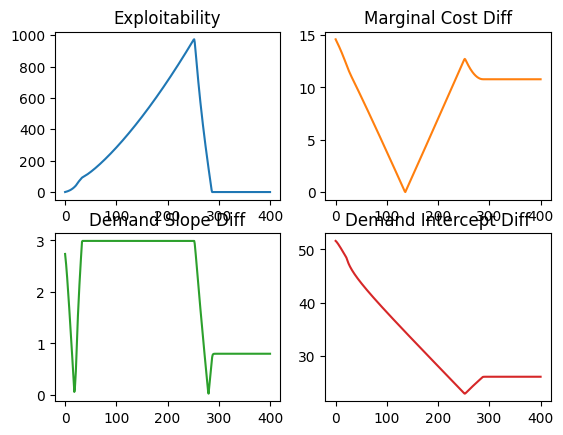

In [ ]:
cost_hist = []
slope_hist = []
intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    slope_hist.append(dist_dict["demand_slope"])
    intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(len(exploit_hist)), exploit_hist)
axs[0, 0].set_title('Exploitability')

axs[0, 1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[0, 1].set_title('Marginal Cost Diff')
axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
axs[1, 0].set_title('Demand Slope Diff')
axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
axs[1, 1].set_title('Demand Intercept Diff')




### Experiment(Max Oracle GD)

In [ ]:
def estimate_all_Bertrand_params_GD(p1_star, p2_star, goal_params, learn_rates, num_iters, epsilon, opt_name = "adam"):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                "demand_slope": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = -1.0, maxval = -1e-2),
                "demand_intercept": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 10.0, maxval = 200.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, epsilon, (p1_star, p2_star))

    def best_response(l_action):
        return get_Bertrand_best_response(l_action, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])
        l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, best_response, l_project, f_project)

    return run_max_oracle_GD(problem, init_params, goal_params, learn_rates, num_iters)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20,
          "demand_slope": -3,
          "demand_intercept": 100}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20


epsilon = 0.01

learn_rate_players = (6e-2, 5e-3)
num_iters = 1000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_all_Bertrand_params_GD(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, epsilon, opt_name)

		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'demand_intercept': Array(91.138, dtype=float32), 'demand_slope': Array(-0.518, dtype=float32), 'marginal_cost': Array(5.474, dtype=float32)}
Follower Predicted: (Array(19.99, dtype=float32, weak_type=True), Array(19.99, dtype=float32, weak_type=True))
							Exploitability: 1171.3341
							Distance to true demand_intercept: 0.088617704808712
							Distance to true demand_slope: 0.8274865746498108
							Distance to true marginal_cost: 0.7263090014457703
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'demand_intercept': Array(90.737, dtype=float32), 'demand_slope': Array(-0.918, dtype=float32), 'marginal_cost': Array(6.066, dtype=float32)}
Follower Predicted: (Array(19.99, dtype=float32, weak_type=True), Array(19.99, dtype=float32, weak_type=True))
							Exploitability: 1006.6876
							Distance to true demand_intercept: 0.09262558

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Demand Intercept Diff')

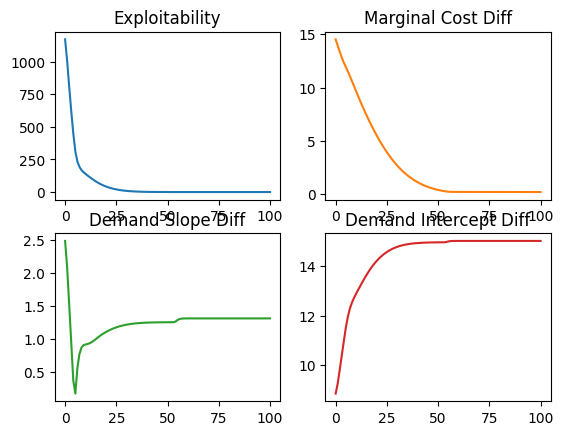

In [ ]:
cost_hist = []
slope_hist = []
intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    slope_hist.append(dist_dict["demand_slope"])
    intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(len(exploit_hist)), exploit_hist)
axs[0, 0].set_title('Exploitability')

axs[0, 1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[0, 1].set_title('Marginal Cost Diff')
axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
axs[1, 0].set_title('Demand Slope Diff')
axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
axs[1, 1].set_title('Demand Intercept Diff')




## Bertrand Competition (Learn Marginal Cost Only)

In [11]:
@jax.jit
def get_Bertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]

    # u1_star = jax.nn.relu(slope*p1_star+intercept)*(p1_star-c) * (p1_star<=p2_star) * ((p1_star<p2_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p1_star<p2_star, p1_star==p2_star, p1_star>p2_star], choicelist=[1, 1/2, 0], default=1)
    u1_star = jax.nn.relu(slope*p1_star+intercept)*(p1_star-c)*condition_constant_star
    # reg1 = jax.nn.relu(slope*p1+intercept)*(p1-c)*(p1<=p2_star)*((p1<p2_star)/2+ 1/2) - u1_star
    condition_constant = jnp.select(condlist=[p1<p2_star, p1==p2_star, p1>p2_star], choicelist=[1, 1/2, 1e-2], default=1)
    reg1 = jax.nn.relu(slope*p1+intercept)*(p1-c)*condition_constant - u1_star


    # u2_star = jax.nn.relu(slope*p2_star+intercept)*(p2_star-c) * (p2_star<=p1_star) * ((p2_star<p1_star)/2+ 1/2)
    condition_constant_star = jnp.select(condlist=[p2_star<p1_star, p2_star==p1_star, p2_star>p1_star], choicelist=[1, 1/2, 0], default=1)
    u2_star = jax.nn.relu(slope*p2_star+intercept)*(p2_star-c)*condition_constant_star
    # reg2 = jax.nn.relu(slope*p2+intercept)*(p2-c)*(p2<=p1_star)*((p2<p1_star)/2+ 1/2) - u2_star
    condition_constant = jnp.select(condlist=[p2<p1_star, p2==p1_star, p2>p1_star], choicelist=[1, 1/2, 0], default=1)
    reg2 = jax.nn.relu(slope*p2+intercept)*(p2-c)*condition_constant - u2_star

    return reg1+reg2
@jax.jit
def get_neg_Bertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star):
    cumul_regret = get_Bertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star)
    return -cumul_regret

def get_Bertrand_best_response(market, slope, intercept, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]

    p_init = 2.0
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2_star >= p1_opt:
        p1 = p1_opt
    elif c < p2_star and p2_star <p1_opt:
        p1 = p2_star - epsilon
    elif p2_star <= c:
        p1 = c

    p_init = 2.0
    p2_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1_star >= p2_opt:
        p2 = p2_opt
    elif c < p1_star and p1_star <p2_opt:
        p2 = p1_star - epsilon
    elif p1_star <= c:
        p2 = c

    return (p1, p2)



# @jax.jit
def get_Bertrand_exploit(p1, p2, market, slope, intercept, epsilon):
    c = market["marginal_cost"]

    p0 = 2.0
    u1 = jax.nn.relu(slope*p1+intercept)*(p1-c) * (p1<=p2) * ((p1<p2)/2+ 1/2)
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p2 >= p1_opt:
        # print("-----------------------------------------CASE 1-------------------------------------------")
        exploit1 = jax.nn.relu(slope*p1_opt+intercept)*(p1_opt-c) - u1
    elif c < p2 and p2 <p1_opt:
        # print("-----------------------------------------CASE 2-------------------------------------------")
        exploit1 = jax.nn.relu(slope*(p2-epsilon)+intercept)*((p2-epsilon)-c) - u1
    elif p2 == c:
        # print("-----------------------------------------CASE 3-------------------------------------------")
        exploit1 = 0 - u1
    else:
        # print("-----------------------------------------CASE 4-------------------------------------------")
        exploit1 = 0 - u1

    u2 = jax.nn.relu(slope*p2+intercept)*(p2-c) * (p2<=p1) * ((p2<p1)/2+ 1/2)
    p2_opt = myjax.minimize(lambda p: -(slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=c), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    if p1 >= p2_opt:
        exploit2 = jax.nn.relu(slope*p2_opt+intercept)*(p2_opt-c) - u2
    elif c < p1 and p1 <p2_opt:
        exploit2 = jax.nn.relu(slope*(p1-epsilon)+intercept)*((p1-epsilon)-c) - u2
    elif p1==c:
        exploit2 = 0 - u2
    else:
        exploit2 = 0 - u2

    return exploit1+exploit2




### Experiment(GDA)

In [18]:
def estimate_Bertrand_params(p1_star, p2_star, goal_params, learn_rates, num_iters, slope, intercept, epsilon, opt_name = "adam"):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def neg_cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_neg_Bertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, slope, intercept, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=100.0), l_action_proj["marginal_cost"])
        # l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        # l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
    #     key_path, c_value = flattened[0]
    #     f_action_proj = lambda x: (jnp.clip(x[0], a_min=c_value), jnp.clip(x[1], a_min=c_value))
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters, opt_name, epsilon)

In [19]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20

slope = -3
intercept = 100
epsilon = 1e-4

learn_rate_players = (5e-2, 3e-2)
num_iters = 6000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_Bertrand_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, epsilon, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.464, dtype=float32)}
Follower Predicted: (Array(5.444, dtype=float32), Array(5.444, dtype=float32))
							Exploitability: 1.6734
							Distance to true marginal_cost: 0.726809024810791
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'marginal_cost': Array(12.729, dtype=float32)}
Follower Predicted: (Array(20.32, dtype=float32), Array(20.226, dtype=float32))
							Exploitability: 296.3271
							Distance to true marginal_cost: 0.3635302186012268
		**************************** Player Iteration: 2000  ****************************
Leader Predicted: {'marginal_cost': Array(1., dtype=float32)}
Follower Predicted: (Array(20.189, dtype=float32), Array(20.226, dtype=float32))
							Exploitability: 811.4840
							Distance to true marginal_cost: 0.949999988079071
		**************************** Player Iteration: 300

Text(0.5, 1.0, 'Marginal Cost Diff')

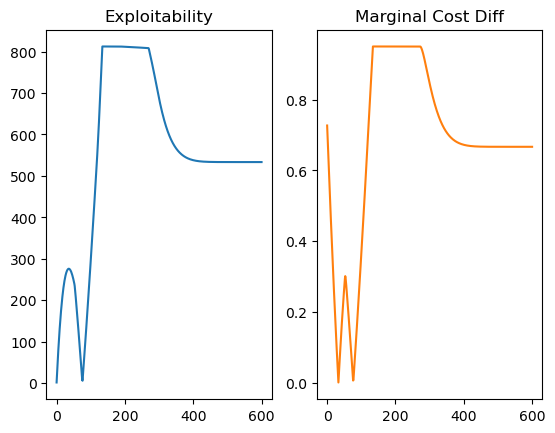

In [20]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

### Experiment(Max Oracle GD)

In [ ]:
def estimate_Bertrand_params_GD(p1_star, p2_star, goal_params, learn_rates, num_iters, slope, intercept, market_epsilon, opt_name = "adam", epsilon=1e-1):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_cumul_regret(*f_action, l_action, slope, intercept, market_epsilon, (p1_star, p2_star))

    def best_response(l_action):
        return get_Bertrand_best_response(l_action, slope, intercept, market_epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_Bertrand_exploit(*f_action, l_action, slope, intercept, market_epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=100.0), l_action_proj["marginal_cost"])
        # l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        # l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
    #     key_path, c_value = flattened[0]
    #     f_action_proj = lambda x: (jnp.clip(x[0], a_min=c_value), jnp.clip(x[1], a_min=c_value))
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, best_response, l_project, f_project)

    return run_max_oracle_GD(problem, init_params, goal_params, learn_rates, num_iters, opt_name, epsilon)

In [ ]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20

slope = -3
intercept = 100
market_epsilon = 0.01

learn_rate_players = (1e-1, 3e-2)
num_iters = 500
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_Bertrand_params_GD(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, market_epsilon, opt_name, 1e-1)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.514, dtype=float32)}
Follower Predicted: (Array(19.424, dtype=float32), Array(19.424, dtype=float32))
							Exploitability: 580.4437
							Distance to true marginal_cost: 0.7243090271949768
		**************************** Player Iteration: 10  ****************************
Leader Predicted: {'marginal_cost': Array(6.347, dtype=float32)}
Follower Predicted: (Array(19.84, dtype=float32), Array(19.84, dtype=float32))
							Exploitability: 546.2056
							Distance to true marginal_cost: 0.6826614141464233
		**************************** Player Iteration: 20  ****************************
Leader Predicted: {'marginal_cost': Array(7.193, dtype=float32)}
Follower Predicted: (Array(19.99, dtype=float32, weak_type=True), Array(19.99, dtype=float32, weak_type=True))
							Exploitability: 512.2286
							Distance to true marginal_cost: 0.6403475999832153
		*****************

Text(0.5, 1.0, 'Marginal Cost Diff')

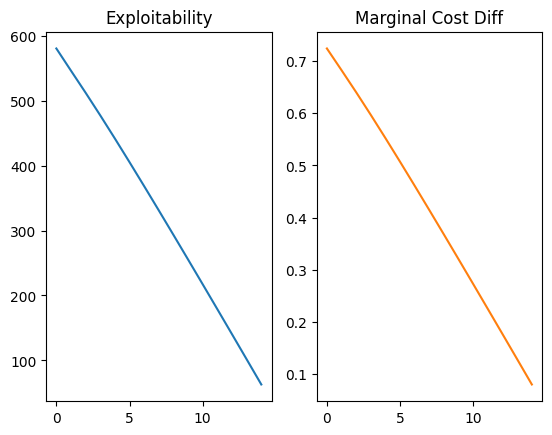

In [ ]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

### Final Experiment

In [ ]:
def generate_Bertrand(num_markets):
    marginal_cost_set = []
    slope_set = []
    intercept_set = []
    p1_star_set = []
    p2_star_set = []
    key = jax.random.PRNGKey(seed)
    for i in range(num_markets):
      key, subkey = jax.random.split(key)
      marginal_cost = jax.random.uniform(subkey, shape = (), minval = 2.0, maxval = 20.0)
      slope = jax.random.uniform(subkey, shape = (), minval = -10.0, maxval = -1e-2)
      intercept = jax.random.uniform(subkey, shape = (), minval = 10.0, maxval = 100.0)
      marginal_cost_set.append(marginal_cost)
      slope_set.append(slope)
      intercept_set.append(intercept)

      p1_star = marginal_cost
      p2_star = marginal_cost
      p1_star_set.append(p1_star)
      p2_star_set.append(p2_star)

    return marginal_cost_set, slope_set, intercept_set, p1_star_set, p2_star_set


In [ ]:
def run_Bertrand_experiment(num_markets, learn_rates, num_iters, market_epsilon, opt_name, epsilon = 1e-1):
    pass_count = 0
    marginal_cost_set, slope_set, intercept_set, p1_star_set, p2_star_set = generate_Bertrand(num_markets)
    for i in range(num_markets):
        print(f"######################################################### Market {i} #########################################################")
        l_goal = {"marginal_cost": marginal_cost_set[i],}
        f_goal = (p1_star_set[i], p2_star_set[i])
        (l_action, f_action), exploit_hist, dist_hist = estimate_Bertrand_params_GD(p1_star_set[i], p2_star_set[i], (l_goal, f_goal), learn_rates, num_iters, slope_set[i], intercept_set[i], market_epsilon, opt_name, epsilon)
        if dist_hist[-1]["marginal_cost"] < epsilon:
            pass_count += 1
    print(f"% of parameters recovered: {pass_count/num_markets}")

    return pass_count/num_markets

percentage_recovered = run_Bertrand_experiment(500, (3e-1, 5e-3), 250, 1e-2, "adam", epsilon = 1e-1)

Streaming output truncated to the last 5000 lines.
		**************************** Player Iteration: 200  ****************************
Leader Predicted: {'marginal_cost': Array(5.414, dtype=float32)}
Follower Predicted: (Array(4.931, dtype=float32), Array(4.931, dtype=float32))
							Exploitability: 0.0000
							Distance to true marginal_cost: 0.18176552653312683
######################################################### Market 57 #########################################################
		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.414, dtype=float32)}
Follower Predicted: (Array(3.766, dtype=float32), Array(3.766, dtype=float32))
							Exploitability: 0.0000
							Distance to true marginal_cost: 0.4205534756183624
		**************************** Player Iteration: 100  ****************************
Leader Predicted: {'marginal_cost': Array(5.414, dtype=float32)}
Follower Predicted: (Array(3.766, dtype=float3

# Smoothed Bertrand Competition

In [36]:
prices=jnp.array([1, 10])
min_price = jnp.min(prices)
print(min_price)
weight = jax.nn.softmax(-1*prices)[0]
print(weight)

p1, p2 = prices
p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
print(p1_opt)

1
0.9998766
18.166655


In [43]:
@jax.jit
def get_sBertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star):
    p1_star, p2_star = f_star
    c = market["marginal_cost"]
    
    # deviation from p1_star
    u1_star=jax.nn.relu(slope*jax.min(f_star)+intercept).clip(0.01)*(p1_star-c)*jax.nn.softmax(-1*f_star)[0]
    new_f = jnp.array([p1, p2_star])
    u1 = jax.nn.relu(slope*jax.min(new_f)+intercept).clip(0.01)*(p1-c)*jax.nn.softmax(-1*new_f)[0]
    reg1 = u1 - u1_star

    # deviation from p2_star
    u2_star=jax.nn.relu(slope*jax.min(f_star)+intercept).clip(0.01)*(p1_star-c)*jax.nn.softmax(-1*f_star)[1]
    new_f = jnp.array([p1_star, p2])
    u2 = jax.nn.relu(slope*jax.min(new_f)+intercept).clip(0.01)*(p1-c)*jax.nn.softmax(-1*new_f)[1]
    reg2 = u2 - u2_star

    return reg1+reg2

@jax.jit
def get_neg_sBertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star):
    cumul_regret = get_sBertrand_cumul_regret(p1, p2, market, slope, intercept, epsilon, f_star)
    return -cumul_regret

# def get_sBertrand_best_response(market, epsilon, f_star):
#     p1_star, p2_star = f_star
#     c = market["marginal_cost"]
#     slope = market["demand_slope"]
#     intercept = market["demand_intercept"]

#     p_init = 2.0
#     p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
#     if p2_star >= p1_opt:
#         p1 = p1_opt
#     elif c < p2_star and p2_star <p1_opt:
#         p1 = p2_star - epsilon
#     elif p2_star <= c:
#         p1 = c

#     p_init = 2.0
#     p2_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p_init, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
#     if p1_star >= p2_opt:
#         p2 = p2_opt
#     elif c < p1_star and p1_star <p2_opt:
#         p2 = p1_star - epsilon
#     elif p1_star <= c:
#         p2 = c

#     return (p1, p2)

# @jax.jit
def get_sBertrand_exploit(p1, p2, market, slope, intercept, epsilon):
    c = market["marginal_cost"]
    prices = jnp.array([p1,p2])
    p0 = 2.0

    u1 = jax.nn.relu(slope*jax.min(prices)+intercept).clip(0.01)*(p1-c)*jax.nn.softmax(-1*prices)[0]
    p1_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    new_prices = jnp.array(p1_opt, p2)
    exploit1 = jax.nn.relu(slope*jax.min(new_prices)+intercept).clip(0.01)*(p1_opt-c)*jax.nn.softmax(-1*new_prices)[0] - u1

    u2 = jax.nn.relu(slope*jax.min(prices)+intercept).clip(0.01)*(p2-c)*jax.nn.softmax(-1*prices)[1]
    p2_opt = myjax.minimize(lambda p: - (slope*p+intercept)*(p-c), p0, proj = lambda p: p.clip(min=1e-2), num_iters=10000, lr=1e-2, name = "adam", verbose=False)
    new_prices = jnp.array(p1, p2_opt)
    exploit2 = jax.nn.relu(slope*jax.min(new_prices)+intercept).clip(0.01)*(p2_opt-c)*jax.nn.softmax(-1*new_prices)[1] - u2

    return exploit1+exploit2


### Experiment(GDA)

In [44]:
def estimate_sBertrand_params(p1_star, p2_star, goal_params, learn_rates, num_iters, slope, intercept, epsilon, opt_name = "adam"):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                }

    init_p1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_p2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_p1, init_p2))


    def cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_sBertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def neg_cumul_regret(l_action, f_action):
        p1, p2 = f_action
        return get_neg_sBertrand_cumul_regret(*f_action, l_action, slope, intercept, epsilon, (p1_star, p2_star))

    def exploit(l_action, f_action):
        p1, p2 = f_action
        return get_sBertrand_exploit(*f_action, l_action, slope, intercept, epsilon)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=1.0, a_max=100.0), l_action_proj["marginal_cost"])
        # l_action_proj["demand_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-10.0, a_max=-1e-2), l_action_proj["demand_slope"])
        # l_action_proj["demand_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=100.0), l_action_proj["demand_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     flattened, _ = jax.tree_util.tree_flatten_with_path(l_action)
    #     key_path, c_value = flattened[0]
    #     f_action_proj = lambda x: (jnp.clip(x[0], a_min=c_value), jnp.clip(x[1], a_min=c_value))
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (jnp.clip(x[0], a_min=1e-2), jnp.clip(x[1], a_min=1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters, opt_name, epsilon)

In [45]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = (20, 20)


# Equilibrium
p1_star = 20
p2_star = 20

slope = -3
intercept = 100
epsilon = 1e-4

learn_rate_players = (5e-2, 3e-2)
num_iters = 6000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_sBertrand_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, epsilon, opt_name)


AttributeError: module 'jax' has no attribute 'min'

Text(0.5, 1.0, 'Marginal Cost Diff')

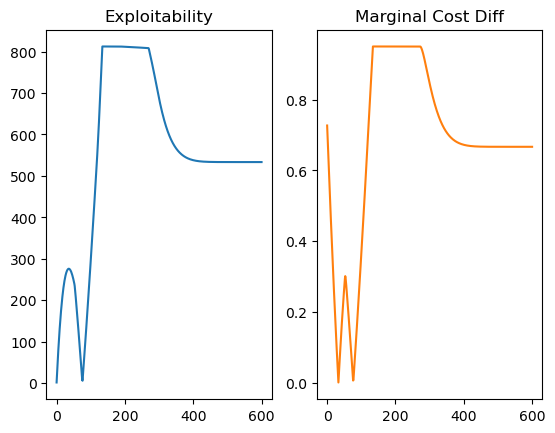

In [ ]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

# Cournot Competition

## Cournot Competition(Learn Price Func + Marginal Cost)

In [14]:
from statsmodels.graphics.gofplots import qqline
@jax.jit
def get_Cournot_cumul_regret(q1, q2, market, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]
    slope = market["price_slope"]
    intercept = market["price_intercept"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    # deviation from q1_star
    reg1 = (price_func(q1+q2_star)-c)*q1 - (price_func(q1_star+q2_star)-c)*q1_star
    # deviation from q2_star
    reg2 = (price_func(q1_star+q2)-c)*q2 - (price_func(q1_star+q2_star)-c)*q2_star

    return reg1+reg2
@jax.jit
def get_neg_Cournot_cumul_regret(q1, q2, market, q_star):
    cumul_regret = get_Cournot_cumul_regret(q1, q2, market, q_star)
    return -1.0 * cumul_regret

def get_Bertrand_best_response(market, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]
    slope = market["price_slope"]
    intercept = market["price_intercept"]

    q1 = (intercept-c)/(-2*slope) - q2_star/2
    q2 = (intercept-c)/(-2*slope) - q1_star/2


    return (q1, q2)


def get_Cournot_exploit(q1, q2, market):
    c = market["marginal_cost"]
    slope = market["price_slope"]
    intercept = market["price_intercept"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    q1_opt = (intercept-c)/(-2*slope) - q2/2
    exploit1 = (price_func(q1_opt+q2)-c)*q1_opt - (price_func(q1+q2)-c)*q1

    q2_opt = (intercept-c)/(-2*slope) - q1/2
    exploit2 = (price_func(q1+q2_opt)-c)*q2_opt - (price_func(q1+q2)-c)*q2

    return exploit1+exploit2

### Experiment(GDA)

In [15]:
def estimate_all_Cournot_params(q1_star, q2_star, goal_params, learn_rates, num_iters, opt_name = "adam"):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0),
                "price_slope": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = -10, maxval = -1e-2),
                "price_intercept": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 10.0, maxval = 100.0),
                }

    init_q1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_q2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_q1, init_q2))


    def cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_cumul_regret(*f_action, l_action, (q1_star, q2_star))

    def neg_cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_neg_Cournot_cumul_regret(*f_action, l_action, (q1_star, q2_star))

    def exploit(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_exploit(*f_action, l_action)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])
        l_action_proj["price_slope"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=-100.0, a_max=-1e-2), l_action_proj["price_slope"])
        l_action_proj["price_intercept"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=10.0, a_max=1000.0), l_action_proj["price_intercept"])

        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (x[0].clip(1e-2), x[1].clip(1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters)

In [16]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20,
          "price_slope": -3,
          "price_intercept": 100}
f_goal = ((100-20)/(-3*-3), (100-20)/(-3*-3))


# Equilibrium
p1_star = (100-20)/(-3*-3)
p2_star = (100-20)/(-3*-3)



learn_rate_players = (1e-4, 5e-2)
num_iters = 10000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_all_Cournot_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, opt_name)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.414, dtype=float32), 'price_intercept': Array(48.406, dtype=float32), 'price_slope': Array(-5.737, dtype=float32)}
Follower Predicted: (Array(5.364, dtype=float32), Array(5.364, dtype=float32))
							Exploitability: 212.0285
							Distance to true marginal_cost: 0.7293139696121216
							Distance to true price_intercept: 0.515944242477417
							Distance to true price_slope: 0.912297248840332
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'marginal_cost': Array(5.305, dtype=float32), 'price_intercept': Array(48.514, dtype=float32), 'price_slope': Array(-5.631, dtype=float32)}
Follower Predicted: (Array(0.01, dtype=float32), Array(0.01, dtype=float32))
							Exploitability: 164.4902
							Distance to true marginal_cost: 0.7347419857978821
							Distance to true price_intercept: 0.5148581266403198
							

Text(0.5, 1.0, 'Price Intercept Diff')

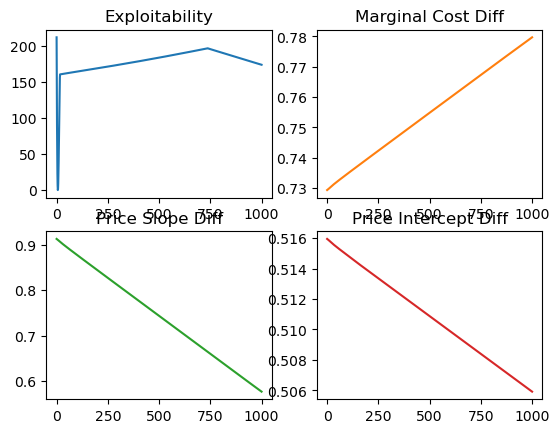

In [17]:
cost_hist = []
slope_hist = []
intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    slope_hist.append(dist_dict["price_slope"])
    intercept_hist.append(dist_dict["price_intercept"])


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(len(exploit_hist)), exploit_hist)
axs[0, 0].set_title('Exploitability')

axs[0, 1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[0, 1].set_title('Marginal Cost Diff')
axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
axs[1, 0].set_title('Price Slope Diff')
axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
axs[1, 1].set_title('Price Intercept Diff')




## Cournot Competition(Learn Marginal Cost)

In [18]:
from statsmodels.graphics.gofplots import qqline
@jax.jit
def get_Cournot_cumul_regret(q1, q2, market, slope, intercept, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    # deviation from q1_star
    reg1 = (price_func(q1+q2_star)-c)*q1 - (price_func(q1_star+q2_star)-c)*q1_star
    # deviation from q2_star
    reg2 = (price_func(q1_star+q2)-c)*q2 - (price_func(q1_star+q2_star)-c)*q2_star

    return reg1+reg2
@jax.jit
def get_neg_Cournot_cumul_regret(q1, q2, market, slope, intercept, q_star):
    cumul_regret = get_Cournot_cumul_regret(q1, q2, market, slope, intercept, q_star)
    return -1.0 * cumul_regret

def get_Bertrand_best_response(market, slope, intercept, q_star):
    q1_star, q2_star = q_star
    c = market["marginal_cost"]

    q1 = (intercept-c)/(-2*slope) - q2_star/2
    q2 = (intercept-c)/(-2*slope) - q1_star/2


    return (q1, q2)


def get_Cournot_exploit(q1, q2, market, slope, intercept):
    c = market["marginal_cost"]

    @jax.jit
    def price_func(q):
       return slope * q + intercept

    q1_opt = (intercept-c)/(-2*slope) - q2/2
    exploit1 = (price_func(q1_opt+q2)-c)*q1_opt - (price_func(q1+q2)-c)*q1

    q2_opt = (intercept-c)/(-2*slope) - q1/2
    exploit2 = (price_func(q1+q2_opt)-c)*q2_opt - (price_func(q1+q2)-c)*q2

    return exploit1+exploit2

### Experiment(GDA)

In [19]:
def estimate_Cournot_params(q1_star, q2_star, goal_params, learn_rates, num_iters, slope, intercept, opt_name = "adam", epsilon = 1e-2):

    init_market_params = {"marginal_cost": jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)}

    init_q1 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_q2 = jax.random.uniform(jax.random.PRNGKey(seed), shape = (), minval = 2.0, maxval = 10.0)
    init_params = (init_market_params, (init_q1, init_q2))


    def cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_cumul_regret(*f_action, l_action, slope, intercept, (q1_star, q2_star))

    def neg_cumul_regret(l_action, f_action):
        q1, q2 = f_action
        return get_neg_Cournot_cumul_regret(*f_action, l_action, slope, intercept, (q1_star, q2_star))

    def exploit(l_action, f_action):
        q1, q2 = f_action
        return get_Cournot_exploit(*f_action, l_action, slope, intercept)

    def project_market(l_action):
        l_action_proj = jax.tree_util.tree_map(lambda y: y, l_action)
        l_action_proj["marginal_cost"] =  jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=100.0), l_action_proj["marginal_cost"])


        return l_action_proj

    # def project_prices(l_action, f_action):
    #     f_action_proj = jax.tree_util.tree_map(lambda y: jnp.clip(y, a_min=2.0, a_max=1000.0), f_action)
    #     return f_action_proj


    l_project = project_market
    f_project = lambda x: (x[0].clip(1e-2), x[1].clip(1e-2))

    problem = (exploit, cumul_regret, neg_cumul_regret, l_project, f_project)

    return run_GDA(problem, init_params, goal_params, learn_rates, num_iters, opt_name, epsilon)

In [26]:
# Real parameters
# marginal cost: c=20
# demand function: D(p)=100-3p
l_goal = {"marginal_cost": 20}
f_goal = ((100-20)/(-3*-3), (100-20)/(-3*-3))


# Equilibrium
p1_star = (100-20)/(-3*-3)
p2_star = (100-20)/(-3*-3)

slope = -3
intercept = 100


learn_rate_players = (1e-2, 5e-3)
num_iters = 20000
opt_name = "adam"

learn_rates = learn_rate_players

(l_action, f_action), exploit_hist, dist_hist = estimate_Cournot_params(p1_star, p2_star, (l_goal, f_goal), learn_rates, num_iters, slope, intercept, opt_name, epsilon = 1e-4)


		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.404, dtype=float32)}
Follower Predicted: (Array(5.419, dtype=float32), Array(5.419, dtype=float32))
							Exploitability: 350.0159
							Distance to true marginal_cost: 0.7298089861869812
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'marginal_cost': Array(2.386, dtype=float32)}
Follower Predicted: (Array(9.527, dtype=float32), Array(9.527, dtype=float32))
							Exploitability: 23.4884
							Distance to true marginal_cost: 0.8806888461112976
		**************************** Player Iteration: 2000  ****************************
Leader Predicted: {'marginal_cost': Array(12.64, dtype=float32)}
Follower Predicted: (Array(10.517, dtype=float32), Array(10.517, dtype=float32))
							Exploitability: 8.8554
							Distance to true marginal_cost: 0.3679938316345215
		**************************** Player Iteration: 3

Text(0.5, 1.0, 'Marginal Cost Diff')

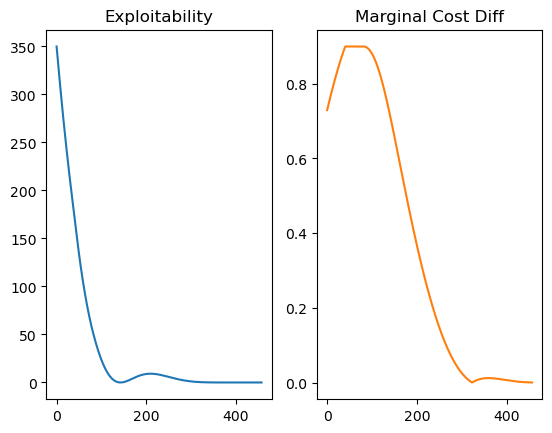

In [27]:
cost_hist = []
# slope_hist = []
# intercept_hist = []
for dist_dict in dist_hist:
    cost_hist.append(dist_dict["marginal_cost"])
    # slope_hist.append(dist_dict["demand_slope"])
    # intercept_hist.append(dist_dict["demand_intercept"])


fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(exploit_hist)), exploit_hist)
axs[0].set_title('Exploitability')

axs[1].plot(range(len(cost_hist)), cost_hist, 'tab:orange')
axs[1].set_title('Marginal Cost Diff')

# axs[1, 0].plot(range(len(slope_hist)), slope_hist, 'tab:green')
# axs[1, 0].set_title('Demand Slope Diff')

# axs[1, 1].plot(range(len(intercept_hist)), intercept_hist, 'tab:red')
# axs[1, 1].set_title('Demand Intercept Diff')

### Final Experiment

In [32]:
def generate_cournot(num_markets):
    marginal_cost_set = []
    slope_set = []
    intercept_set = []
    q1_star_set = []
    q2_star_set = []
    key = jax.random.PRNGKey(seed)
    for i in range(num_markets):
      key, subkey = jax.random.split(key)
      marginal_cost = jax.random.uniform(subkey, shape = (), minval = 2.0, maxval = 20.0)
      slope = jax.random.uniform(subkey, shape = (), minval = -10.0, maxval = -1e-2)
      intercept = jax.random.uniform(subkey, shape = (), minval = 10.0, maxval = 100.0)
      marginal_cost_set.append(marginal_cost)
      slope_set.append(slope)
      intercept_set.append(intercept)

      q1_star = (intercept-marginal_cost)/(-3*slope)
      q2_star = (intercept-marginal_cost)/(-3*slope)
      q1_star_set.append(q1_star)
      q2_star_set.append(q2_star)

    return marginal_cost_set, slope_set, intercept_set, q1_star_set, q2_star_set


In [38]:
def run_cournot_experiment(num_markets, learn_rates, num_iters, opt_name, epsilon = 1e-1):
    pass_count = 0
    final_exploits = []
    marginal_cost_set, slope_set, intercept_set, q1_star_set, q2_star_set = generate_cournot(num_markets)
    for i in range(num_markets):
        print(f"######################################################### Market {i} #########################################################")
        l_goal = {"marginal_cost": marginal_cost_set[i],}
        f_goal = (q1_star_set[i], q2_star_set[i])
        (l_action, f_action), exploit_hist, dist_hist = estimate_Cournot_params(q1_star_set[i], q2_star_set[i], (l_goal, f_goal), learn_rates, num_iters, slope_set[i], intercept_set[i], opt_name, epsilon)
        final_exploits.append(exploit_hist[-1])
        if dist_hist[-1]["marginal_cost"] < epsilon:
            pass_count += 1
    print("-----------------------------------------------------------------------------------------------------\n")
    print(f"% of parameters recovered: {pass_count/num_markets}")
    print(f"Median exploitability: {np.median(np.array(final_exploits))}")

    return pass_count/num_markets

percentage_recovered = run_cournot_experiment(100, (1e-2, 5e-3), 10000, "adam", epsilon = 1e-4)

######################################################### Market 0 #########################################################
		**************************** Player Iteration: 0  ****************************
Leader Predicted: {'marginal_cost': Array(5.404, dtype=float32)}
Follower Predicted: (Array(5.419, dtype=float32), Array(5.419, dtype=float32))
							Exploitability: 3075.1951
							Distance to true marginal_cost: 0.7073055505752563
		**************************** Player Iteration: 1000  ****************************
Leader Predicted: {'marginal_cost': Array(2., dtype=float32)}
Follower Predicted: (Array(10.317, dtype=float32), Array(10.317, dtype=float32))
							Exploitability: 2341.6260
							Distance to true marginal_cost: 0.8916712999343872
		**************************** Player Iteration: 2000  ****************************
Leader Predicted: {'marginal_cost': Array(2., dtype=float32)}
Follower Predicted: (Array(14.862, dtype=float32), Array(14.862, dtype=float32))
							Exploit